<a href="https://colab.research.google.com/github/florinOK/amr/blob/colab/vae-sentences/vae-syntax-sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Generating Sentences from a Continuous Space](https://arxiv.org/pdf/1511.06349.pdf)  
[Reasoning about Entailment with Neural Attention](https://arxiv.org/pdf/1509.06664.pdf)  
[Deconvolutional Latent-Variable Model for Text Sequence Matching](https://arxiv.org/pdf/1709.07109.pdf)  

---
https://github.com/baaesh/DeConv-VAE-pytorch  
https://github.com/Toni-Antonova/VAE-Text-Generation  
https://github.com/alexeyev/Keras-Generating-Sentences-from-a-Continuous-Space  


Идея в том, чтобы отсортировать семантические элементы предложения  
(лицо, признаки лица, действие, обстоятельства действия, прочее).

Канонический порядок должен обеспечить возможность сравнивать два предложения.  
Сортировка должна зависеть как от скрытого представления элемента, так и от его соседей.



In [1]:
! nvidia-smi

Sun Oct 18 15:37:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [1]:
# SNLI
! curl https://nlp.stanford.edu/projects/snli/snli_1.0.zip -o snli_1.0.zip
! unzip -o snli_1.0.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  59.0M      0  0:00:01  0:00:01 --:--:-- 59.0M
Archive:  snli_1.0.zip
  inflating: data/snli_1.0/.DS_Store  
  inflating: data/__MACOSX/snli_1.0/._.DS_Store  
 extracting: data/snli_1.0/Icon      
  inflating: data/__MACOSX/snli_1.0/._Icon  
  inflating: data/snli_1.0/README.txt  
  inflating: data/__MACOSX/snli_1.0/._README.txt  
  inflating: data/snli_1.0/snli_1.0_dev.jsonl  
  inflating: data/snli_1.0/snli_1.0_dev.txt  
  inflating: data/snli_1.0/snli_1.0_test.jsonl  
  inflating: data/snli_1.0/snli_1.0_test.txt  
  inflating: data/snli_1.0/snli_1.0_train.jsonl  
  inflating: data/snli_1.0/snli_1.0_train.txt  
  inflating: data/__MACOSX/._snli_1.0  


In [3]:
# QQP

In [4]:
# PTB

In [ ]:
# Glove
! wget http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip glove.840B.300d.zip -d data/glove

--2020-08-30 12:12:42--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-08-30 12:12:42--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-08-30 12:12:43--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

# Code

In [2]:
import re
import copy
import json
import time
import tqdm
import logging
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


from IPython import display

In [3]:
p = sns.color_palette()

pd.set_option('display.max_rows', 64)
pd.set_option('display.max_columns', 64)
pd.set_option('display.max_colwidth', 1024)

logging.basicConfig(level='INFO', format="%(asctime)s [%(levelname)-5.5s] [%(funcName)-32s]  %(message)s")

In [4]:
# config

EMBS = 'data/glove/glove.840B.300d.txt'
TEST_DATASET = 'data/snli_1.0/snli_1.0_test.jsonl'
TRAIN_DATASET = 'data/snli_1.0/snli_1.0_train.jsonl'


In [5]:
def load_dataset(path):
    dataset = []
    with open(path) as fp:
        for line in fp.readlines():
            dataset.append(json.loads(line))
    return pd.DataFrame(dataset)


test_dataset = load_dataset(TEST_DATASET)
train_dataset = load_dataset(TRAIN_DATASET)

In [6]:
train_dataset.shape, test_dataset.shape  # (550152, 10)

((550152, 10), (10000, 10))

In [7]:
train_dataset.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],3416050480.jpg#4,neutral,3416050480.jpg#4r1n,A person on a horse jumps over a broken down airplane.,( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) ),(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .))),A person is training his horse for a competition.,( ( A person ) ( ( is ( ( training ( his horse ) ) ( for ( a competition ) ) ) ) . ) ),(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))
1,[contradiction],3416050480.jpg#4,contradiction,3416050480.jpg#4r1c,A person on a horse jumps over a broken down airplane.,( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) ),(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .))),"A person is at a diner, ordering an omelette.","( ( A person ) ( ( ( ( is ( at ( a diner ) ) ) , ) ( ordering ( an omelette ) ) ) . ) )","(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (PP (IN at) (NP (DT a) (NN diner))) (, ,) (S (VP (VBG ordering) (NP (DT an) (NN omelette))))) (. .)))"
2,[entailment],3416050480.jpg#4,entailment,3416050480.jpg#4r1e,A person on a horse jumps over a broken down airplane.,( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) ),(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .))),"A person is outdoors, on a horse.","( ( A person ) ( ( ( ( is outdoors ) , ) ( on ( a horse ) ) ) . ) )","(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (ADVP (RB outdoors)) (, ,) (PP (IN on) (NP (DT a) (NN horse)))) (. .)))"
3,[neutral],2267923837.jpg#2,neutral,2267923837.jpg#2r1n,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at camera ) ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smiling) (CC and) (VBG waving) (PP (IN at) (NP (NN camera))))))),They are smiling at their parents,( They ( are ( smiling ( at ( their parents ) ) ) ) ),(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VBG smiling) (PP (IN at) (NP (PRP$ their) (NNS parents)))))))
4,[entailment],2267923837.jpg#2,entailment,2267923837.jpg#2r1e,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at camera ) ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smiling) (CC and) (VBG waving) (PP (IN at) (NP (NN camera))))))),There are children present,( There ( ( are children ) present ) ),(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NNS children)) (ADVP (RB present)))))


In [8]:
# # DEBUG mode 0
# train_dataset = test_dataset = test_dataset[:1024]
# train_dataset.shape, test_dataset.shape

# DEBUG mode 1
test_dataset = train_dataset[:1024]
train_dataset = train_dataset[:100000]
train_dataset.shape, test_dataset.shape

((100000, 10), (1024, 10))

# Phrase Structure

In [9]:
def parse_brackets(string):
    regex = r'([^\(\)\s]+|[\(\)\s])'
    items = re.findall(regex, string)
    items = [i for i in items if i != ' ']
    string = ' '.join(items)
    string = string.replace(f'( ', '(')
    return string


def parse_phrase_structure(string):
    items = string.split()
    
    nodes = [{'index': 0, 'label': 'ROOT', 'words': [], 'childs': []}]
    words = []
    parents = [0]
    for item in items:
        if item.startswith('('):
            # link child to parent
            nodes[parents[-1]]['childs'].append(len(nodes))
            # add node
            node = {
                'index': len(nodes),
                'label': item[1:],
                'words': [],
                'childs': []
            }
            nodes.append(node)
            # add new parent
            parents.append(len(nodes) - 1)
        
        elif item == ')':
            # update last parent
            parents = parents[:-1]
        
        else:
            # add word to last node
            words.append(item)
            nodes[parents[-1]]['words'].append({'word': item, 'index': len(words) - 1})

    return nodes


In [10]:
def get_branches(nodes, index, branch):
    branch += [nodes[index]]
    childs = nodes[index]['childs']
    if childs:
        for child_index in childs:
            yield from get_branches(nodes, child_index, copy.deepcopy(branch))
    else:
        yield branch


def get_node_branch(branch):
    branch_word = branch[-1]['words'][0]
    branch_word['label'] = '-'.join([node['label'] for node in branch if node['label'] not in ['ROOT', 'S']])
    return branch_word


In [11]:
def process_word(word):
    return word.lower()

def process_sentence_structure(dataset, column):
    sentence_words = []
    sentence_labels = []

    for string in dataset[column]:
        string = parse_brackets(string)

        nodes = parse_phrase_structure(string)
        nodes = [get_node_branch(branch) for branch in get_branches(nodes, 0, [])]

        words = [process_word(node['word']) for node in sorted(nodes, key=lambda x: x['index'])]
        labels = [node['label'] for node in sorted(nodes, key=lambda x: x['index'])]

        sentence_words.append(words)
        sentence_labels.append(labels)
    
    dataset[f'{column}_words'] = sentence_words
    dataset[f'{column}_labels'] = sentence_labels
    return dataset


In [12]:
# ROOT-ROOT-S-.          # конец предложения
# ROOT-ROOT-NP-.         # конец предложения
# 
# ROOT-ROOT-S-NP-DT      # артикль простого подлежащего "a man"
# ROOT-ROOT-S-NP-NN      # существительное простого подлежащего "a man"
# 
# ROOT-ROOT-S-NP-NP-DT   # артикль сложного подлежащего "a few people in a restaurant"
# ROOT-ROOT-S-NP-NP-NN   # существительное сложного подлежащего "a few people in a restaurant"
# ROOT-ROOT-S-NP-PP-IN   # предлог сложного подлежащего "a few people in a restaurant"
# 
# ROOT-ROOT-S-VP-VBZ     # to be простого сказуемого "a man is drinking"
# ROOT-ROOT-S-VP-VP-VBG  # глагол простого сказуемого "a man is drinking"
# ROOT-ROOT-S-VP-PP-IN   # предлог сложного сказуемого "a man is drinking in a bar"

# Vocab

In [13]:
class WordModel:

    def preprocess_word(self, word):
        word = word.lower()
        return word

    def preprocess_words(self, words):
        words = [word for word in words if word != ' ']  # hack short length: words = [word for word in words[:8] if word != ' ']
        return words
    
    def parse_corpus(self, sentences):
        words = []
        for sentence in sentences:
            words += self.preprocess_words(sentence)
        return words


In [14]:
class WordVocab:

    def __init__(self, max_size_vocab=100000):
        self.max_size_vocab = max_size_vocab
        self.vocab = None
        self.vocab_reversed = None
        self.util_vocab = {'[PAD]': 0, '[UNK]': 1}
        self.util_vocab_reversed = {v: k for k, v in self.util_vocab.items()}
    
    @property
    def vocab_size(self):
        return len(self.vocab)
    
    def create_vocab(self, words):
        word_counts = collections.Counter(words)
        word_counts = word_counts.most_common(self.max_size_vocab)

        initial_index = len(self.util_vocab)
        self.vocab = {
            **self.util_vocab,
            **{word: i for i, (word, _) in enumerate(word_counts, initial_index)}
        }
        self.vocab_reversed = {v: k for k, v in self.vocab.items()}
    
    def pad_words(self, words, max_length):
        words = words + ['[PAD]'] * (max_length - len(words))
        return words[:max_length]

    def encode_words(self, words):
        unk_code = self.vocab['[UNK]']
        return [self.vocab.get(word, unk_code) for word in words]
    
    def decode_words(self, words):
        unk_word = '[UNK]'
        return [self.vocab_reversed.get(word, unk_word) for word in words]


In [15]:
%%time
test_dataset = process_sentence_structure(test_dataset, column='sentence1_parse')
test_dataset = process_sentence_structure(test_dataset, column='sentence2_parse')

CPU times: user 1.97 s, sys: 0 ns, total: 1.97 s
Wall time: 1.97 s


In [16]:
%%time
train_dataset = process_sentence_structure(train_dataset, column='sentence1_parse')
train_dataset = process_sentence_structure(train_dataset, column='sentence2_parse')

# CPU times: user 20min 40s, sys: 1.85 s, total: 20min 42s
# Wall time: 20min 42s

CPU times: user 3min 3s, sys: 7.71 ms, total: 3min 4s
Wall time: 3min 4s


In [17]:
word_model = WordModel()

train_words = word_model.parse_corpus(train_dataset['sentence1_parse_words'])
train_words += word_model.parse_corpus(train_dataset['sentence2_parse_words'])

In [18]:
label_model = WordModel()

train_labels = label_model.parse_corpus(train_dataset['sentence1_parse_labels'])
train_labels += label_model.parse_corpus(train_dataset['sentence2_parse_labels'])

In [19]:
max_size_vocab = 8000


word_vocab = WordVocab(max_size_vocab)
word_vocab.create_vocab(train_words)

In [20]:
word_vocab.vocab_size, len([word for word in train_words if word in word_vocab.vocab]) / len(train_words)

(8002, 0.9919986938115715)

In [21]:
max_size_label_vocab = 8000


label_vocab = WordVocab(max_size_label_vocab)
label_vocab.create_vocab(train_labels)

In [22]:
label_vocab.vocab_size, len([label for label in train_labels if label in label_vocab.vocab]) / len(train_labels)

(8002, 0.9866977157037586)

# Embs

In [23]:
emb_size = 300

In [35]:
# embeddings = [
#     word_embeddings[word] if word in word_embeddings else np.random.uniform(-0.05, 0.05, 300)
#     for word, _ in sorted(word_vocab.vocab.items(), key=lambda x: x[1])
# ]
# embeddings = np.array(embeddings)

### pretrained

In [ ]:
word_embeddings = {}

with open(EMBS, 'r', encoding='utf-8') as fp:
    for line in fp:
        values = line.strip().split()
        word = ' '.join(values[:-300])
        word_embeddings[word] = np.asarray(values[-300:], 'float32')


In [ ]:
len(word_embeddings)

2195895

In [ ]:
# space is part of word
# [word for word in word_embeddings if ' ' in word]

##### check words without embeddings

In [ ]:
# check word embeddings
len([word for word in word_vocab.vocab if word in word_embeddings]) / word_vocab.vocab_size

0.9991252186953262

In [ ]:
[word for word in word_vocab.vocab if word not in word_embeddings]

['[PAD]',
 '[UNK]',
 'rollerskaters',
 'surfboarder',
 'graffited',
 'parasailer',
 'boogieboard']

##### init emb matrix

In [ ]:
embeddings = [
    word_embeddings[word] if word in word_embeddings else np.random.uniform(-0.05, 0.05, 300)
    for word, _ in sorted(word_vocab.vocab.items(), key=lambda x: x[1])
]
embeddings = np.array(embeddings)

In [ ]:
embeddings.shape

(8002, 300)

# Dataset

In [24]:
max_length = 32
batch_size = 1024  # 64

test_size = 1000
train_size = 1000

In [25]:
# check max_length
lengths = [len(sentence) for sentence in train_dataset['sentence1_parse_words']]
np.min(lengths), np.max(lengths), np.mean(lengths), len([length for length in lengths if length < max_length]) / len(lengths)

(2, 82, 13.95736, 0.98548)

In [26]:
def process_words(words):
    words = word_vocab.pad_words(words, max_length)
    words = word_vocab.encode_words(words)
    return words


def process_labels(labels):
    labels = label_vocab.pad_words(labels, max_length)
    labels = label_vocab.encode_words(labels)
    return labels


def get_dataset(dataset):
    dataset_words = [process_words(words) for words in dataset['sentence1_parse_words']]
    dataset_words += [process_words(words) for words in dataset['sentence2_parse_words']]
    dataset_words = np.array(dataset_words)

    dataset_labels = [process_labels(labels) for labels in dataset['sentence1_parse_labels']]
    dataset_labels += [process_labels(labels) for labels in dataset['sentence2_parse_labels']]
    dataset_labels = np.array(dataset_labels)

    dataset = {
        'words': dataset_words,
        'labels': dataset_labels
    }
    return dataset

# 
test_sentences = (
    tf.data.Dataset.from_tensor_slices(get_dataset(test_dataset))
    .shuffle(test_size)
    .batch(batch_size)
)
train_sentences = (
    tf.data.Dataset.from_tensor_slices(get_dataset(train_dataset))
    .shuffle(train_size)
    .batch(batch_size)
)

# Model

### Positional Encoding

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


##### *how it works*

(1, 50, 512)


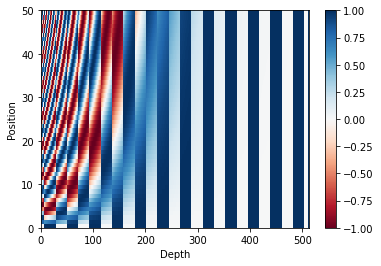

In [ ]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.xlim((0, 512))
plt.xlabel('Depth')
plt.ylabel('Position')
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.colorbar()
plt.show()

### Attention Function

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
                to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights


##### *how it works*

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)


In [ ]:
# np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[1.000000e+01 9.276601e-25]], shape=(1, 2), dtype=float32)


### Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


In [31]:
def sample_gumbel(shape, eps=1e-20):
  u = tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)
  return -tf.math.log(-tf.math.log(u + eps) + eps)


def sinkhorn(log_alpha, length, n_iters=20):
  for _ in tf.range(n_iters):
    log_alpha -= tf.math.reduce_logsumexp(log_alpha, axis=2, keepdims=True)
    log_alpha -= tf.math.reduce_logsumexp(log_alpha, axis=1, keepdims=True)
#   return tf.exp(log_alpha)
  return log_alpha


def gumbel_sinkhorn(log_alpha, temperature=1.0, noise=1.0, n_iters=20):
    if noise:
      noise = sample_gumbel(log_alpha.shape) * noise
    log_alpha = (log_alpha + noise) / temperature
    return sinkhorn(log_alpha, n_iters)


##### *how it works*

In [239]:
# b=64, s=32, logits=8k

batch_size = 2
max_length = 4
hidden_size = 5

lengths = tf.constant([1, 2], dtype=tf.int64)


# 
mask = tf.sequence_mask(
    lengths, maxlen=max_length
)
mask = tf.cast(tf.logical_not(mask), dtype=tf.float32)

mask = tf.tile(mask, [1, hidden_size])
mask = tf.reshape(mask, [batch_size, hidden_size, max_length])
mask = tf.transpose(mask, [0, 2, 1])


# 
log_alpha = [
    [
        [0.75, 0.05, 0.19, 0.01, 0.01],  # A
        [0.01, 0.05, 0.01, 0.01, 1.00],  # B
        [0.01, 0.05, 0.01, 0.01, 1.00],  # PAD
        [0.01, 0.05, 0.01, 0.01, 1.00],  # PAD
    ],
    [
        [0.75, 0.05, 0.19, 0.01, 0.01],  # A
        [0.19, 0.05, 0.75, 0.01, 0.01],  # B
        [0.01, 0.05, 0.01, 0.01, 1.00],  # PAD
        [0.01, 0.05, 0.01, 0.01, 1.00],  # PAD
    ]
]
log_alpha = tf.constant(log_alpha, dtype=tf.float32)


with tf.GradientTape() as tape:
    mask
    log_alpha -= tf.math.reduce_logsumexp(log_alpha + mask * 1e3, axis=2, keepdims=True)
    log_alpha -= tf.math.reduce_logsumexp(log_alpha + mask * 1e3, axis=1, keepdims=True)
    log_alpha = tf.exp(log_alpha)

    log_alpha -= tf.math.reduce_logsumexp(log_alpha + mask * 1e3, axis=2, keepdims=True)
    log_alpha -= tf.math.reduce_logsumexp(log_alpha + mask * 1e3, axis=1, keepdims=True)
    log_alpha = tf.exp(log_alpha)

mask, log_alpha

(<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[0.2788722 , 0.24701703, 0.2538159 , 0.24701622, 0.22099805],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]],
 
        [[0.27975768, 0.24941832, 0.23515755, 0.24941799, 0.23492923],
         [0.23515755, 0.24941832, 0.2797576 , 0.24941799, 0.23492923],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]]],
       dtype=float32)>)

In [263]:
inf = np.inf

log_alpha = [
    [
        [0.75, 0.05, 0.19, 0.01, 0.01],  # A
        [0.19, 0.05, 0.75, 0.01, 0.01],  # B
        [0.01, 0.05, 0.01, 0.01, 1.00],  # PAD
        [0.01, 0.05, 0.01, 0.01, 1.00],  # PAD
    ],
    [
        [0.75, 0.05, 0.19, 0.01, 0.01],  # A
        [0.19, 0.05, 0.75, 0.01, 0.01],  # B
        [0.01, 0.05, 0.01, 0.01, 0.00],  # PAD
        [0.01, 0.05, 0.01, 0.01, 0.00],  # PAD
    ],
    [
        [0.75, 0.05, 0.19, 0.01, 0.01],  # A
        [0.19, 0.05, 0.75, 0.01, 0.01],  # B
        [-inf, -inf, -inf, -inf, -inf],  # PAD
        [-inf, -inf, -inf, -inf, -inf],  # PAD
    ],
]
# log_alpha = np.random.rand(4, 4, 4)

log_alpha = tf.constant(log_alpha, dtype=tf.float32)


with tf.GradientTape() as tape:
    log_alpha = gumbel_sinkhorn(
        log_alpha, temperature=0.19, noise=0.1, n_iters=10
    )

log_alpha, tf.math.log(log_alpha)

(<tf.Tensor: shape=(3, 4, 5), dtype=float32, numpy=
 array([[[0.92109287, 0.13772646, 0.09242249, 0.10207093, 0.00129111],
         [0.02454666, 0.30682516, 0.8129591 , 0.09811517, 0.00817495],
         [0.02888179, 0.23373286, 0.02288803, 0.25183755, 0.70953393],
         [0.02547874, 0.32171553, 0.07173035, 0.5479764 , 0.281     ]],
 
        [[0.81200325, 0.21342234, 0.05571639, 0.107598  , 0.06165284],
         [0.04968697, 0.08016108, 0.8587835 , 0.10679868, 0.1536327 ],
         [0.06550746, 0.32574737, 0.03631322, 0.6011184 , 0.22161661],
         [0.07280227, 0.38066918, 0.04918694, 0.18448497, 0.5630979 ]],
 
        [[       nan,        nan,        nan,        nan,        nan],
         [       nan,        nan,        nan,        nan,        nan],
         [       nan,        nan,        nan,        nan,        nan],
         [       nan,        nan,        nan,        nan,        nan]]],
       dtype=float32)>, <tf.Tensor: shape=(3, 4, 5), dtype=float32, numpy=
 array([[[-0.

In [255]:
inf = np.inf

log_alpha = [
    [
        [0.75, 0.05, 0.19, 0.01],  # A
        [0.19, 0.05, 0.75, 0.01],  # B
        [0.01, 0.75, 0.01, 0.00],  # PAD
        [0.01, 0.05, 0.01, 1.00],  # PAD
    ],
]
# log_alpha = np.random.rand(4, 4, 4)

log_alpha = tf.constant(log_alpha, dtype=tf.float32)


with tf.GradientTape() as tape:
    log_alpha = gumbel_sinkhorn(
        log_alpha, temperature=0.2, noise=0.1, n_iters=100
    )

log_alpha

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[0.91433096, 0.03264742, 0.04765708, 0.00536499],
        [0.05261366, 0.03161505, 0.8952369 , 0.02053461],
        [0.02616647, 0.93055004, 0.02976672, 0.01351739],
        [0.00688877, 0.00518755, 0.02733931, 0.96058303]]], dtype=float32)>

In [96]:
soft_perms_inf

<tf.Tensor: shape=(4, 3, 2), dtype=float32, numpy=
array([[[0.37884277, 0.28782383],
        [0.26742694, 0.39923975],
        [0.35373026, 0.31293637]],

       [[0.46695518, 0.19971152],
        [0.29818264, 0.36848402],
        [0.23486218, 0.4318045 ]],

       [[0.36098942, 0.30567726],
        [0.34798416, 0.31868243],
        [0.2910263 , 0.37564036]],

       [[0.27470788, 0.3919588 ],
        [0.28544784, 0.38121885],
        [0.43984425, 0.22682239]]], dtype=float32)>

In [97]:
log_alpha_w_noise

<tf.Tensor: shape=(4, 3, 2), dtype=float32, numpy=
array([[[0.69348073, 0.39238495],
        [0.57456255, 0.9489553 ],
        [0.71029997, 0.5614424 ]],

       [[1.0537262 , 0.5446054 ],
        [0.47288078, 1.0248101 ],
        [0.19754723, 1.1467597 ]],

       [[0.7363186 , 0.4338076 ],
        [0.8279322 , 0.6037785 ],
        [0.66436553, 0.78339195]],

       [[0.34069693, 0.6689483 ],
        [0.47743994, 0.73955715],
        [1.2744286 , 0.58497804]]], dtype=float32)>

### VAE

In [27]:
latent_dim = 512

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()

        self.seq = tf.keras.layers.InputLayer(input_shape=(max_length))
        self.emb = tf.keras.layers.Embedding(
            word_vocab.vocab_size, emb_size,
            # embeddings_initializer=tf.keras.initializers.Constant(embeddings),
            # trainable=False
        )

        self.conv_1 = tf.keras.layers.Conv1D(
            filters=emb_size, kernel_size=3, strides=2, activation='relu'
        )
        self.conv_2 = tf.keras.layers.Conv1D(
            filters=512, kernel_size=3, strides=2, activation='relu'
        )
        self.conv_3 = tf.keras.layers.Conv1D(
            filters=512, kernel_size=3, strides=2, activation='relu'
        )

        self.flatten = tf.keras.layers.Flatten()
        self.latent = tf.keras.layers.Dense(latent_dim + latent_dim)

    def call(self, x, training=None):
        seq = self.seq(x)    # (64, 32)
        emb = self.emb(seq)  # (64, 32, 300)

        conv_1 = self.conv_1(emb)     # (64, 15, 300)
        conv_2 = self.conv_2(conv_1)  # (64, 7, 512)
        conv_3 = self.conv_3(conv_2)  # (64, 3, 512)

        flatten = self.flatten(conv_3)  # (64, 1536)
        latent = self.latent(flatten)   # (64, 1024)
        return latent


In [29]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()

        self.seq = tf.keras.layers.InputLayer(input_shape=(latent_dim,))
        self.dense = tf.keras.layers.Dense(units=4 * 512, activation=tf.nn.relu)
        self.reshape = tf.keras.layers.Reshape(target_shape=(4, 512))

        self.conv_1 = tf.keras.layers.Conv1DTranspose(
            filters=512, kernel_size=3, strides=2, padding='same', activation='relu'
        )
        self.conv_2 = tf.keras.layers.Conv1DTranspose(
            filters=512, kernel_size=3, strides=2, padding='same', activation='relu'
        )
        self.conv_3 = tf.keras.layers.Conv1DTranspose(
            filters=emb_size, kernel_size=3, strides=2, padding='same', activation='relu'
        )

        # No activation
        self.embeddings = tf.keras.layers.Conv1DTranspose(
            filters=emb_size, kernel_size=1, strides=1, padding='same'
        )
        self.word_logits = tf.keras.layers.Conv1DTranspose(
            filters=word_vocab.vocab_size, kernel_size=1, strides=1, padding='same'
        )
        self.label_logits = tf.keras.layers.Conv1DTranspose(
            filters=label_vocab.vocab_size, kernel_size=1, strides=1, padding='same'
        )

    def call(self, x, training=None):
        seq = self.seq(x)        # (64, 512)
        seq = self.dense(seq)    # (64, 2048)
        seq = self.reshape(seq)  # (64, 4, 512)

        conv_1 = self.conv_1(seq)     # (64, 8, 512)
        conv_2 = self.conv_2(conv_1)  # (64, 16, 512)
        conv_3 = self.conv_3(conv_2)  # (64, 32, 300)

        embeddings = self.embeddings(conv_3)      # (64, 32, 300)
        word_logits = self.word_logits(conv_3)    # (64, 32, 8002)
        label_logits = self.label_logits(conv_3)  # (64, 32, 8002)
        return embeddings, word_logits, label_logits


In [30]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder()
        self.decoder = Decoder()

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, log_variance = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, log_variance

    def reparameterize(self, mean, log_variance):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_variance * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        embeddings, word_logits, label_logits = self.decoder(z)
        if apply_sigmoid:
            word_logits = tf.sigmoid(word_logits)
            label_logits = tf.sigmoid(label_logits)
        return embeddings, word_logits, label_logits


In [31]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, log_variance, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-log_variance) + log_variance + log_2pi), axis=raxis)


def compute_loss(model, x):
    # TODO: разделить encode на две части
    #       latent: чтобы сразу учитывать labels
    #       mean, variance: чтобы потом декодировать предложение
    # 
    # С одной стороны, чем дальше от входа, тем сложнее обучение
    # С другой стороны, это плохая идея, потому что labels зависят от контекста
    mean, log_variance = model.encode(x['words'])
    z = model.reparameterize(mean, log_variance)

    embeddings, word_logits, label_logits = model.decode(z)

    words = tf.one_hot(x['words'], depth=word_vocab.vocab_size, dtype='float32')
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=word_logits, labels=words)
    word_loss = -tf.reduce_sum(cross_entropy, axis=[1, 2])

    labels = tf.one_hot(x['labels'], depth=label_vocab.vocab_size, dtype='float32')
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=label_logits, labels=labels)
    label_loss = -tf.reduce_sum(cross_entropy, axis=[1, 2])

    # log_px_z = word_loss + 0.01 * label_loss
    log_px_z = word_loss + label_loss
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, log_variance)
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)


@tf.function
def train_step(model, sample, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, sample)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [32]:
def print_words_and_labels(words, labels, length=None):
    length = length or len(words)
    sentence = ' '.join(words[:length])

    words = ' '.join(f'{str(item):<15s}_'[:16] for item in words)
    labels = ' '.join(f'{str(item):<15s}_'[:16] for item in labels)

    string = f"""
        sentence: {sentence}
        words   : {words}
        labels  : {labels}
    """
    print(string)


In [33]:
def decode_sentences(sentences):
    sentences = [word_vocab.decode_words(sentence) for sentence in sentences]
    sentences = [' '.join(sentence) for sentence in sentences]
    return sentences


def generate_sentences(model, sample):
    words = [word_vocab.decode_words(words) for words in sample['words'].numpy()]
    labels = [label_vocab.decode_words(words) for words in sample['labels'].numpy()]

    mean, log_variance = model.encode(sample['words'])
    z = model.reparameterize(mean, log_variance)
    embeddings, word_predictions, label_predictions = model.sample(z)

    word_predictions = np.argmax(word_predictions, axis=-1)
    label_predictions = np.argmax(label_predictions, axis=-1)

    word_predictions = [word_vocab.decode_words(ws) for ws in word_predictions]
    label_predictions = [label_vocab.decode_words(ls) for ls in label_predictions]
    return list(zip(words, labels, word_predictions, label_predictions))


# Training

In [34]:
tf.keras.backend.clear_session()

In [35]:
epochs = 100
num_samples = 4

model = CVAE(latent_dim)

In [36]:
for sample in test_sentences.take(1):
    test_sample = sample


In [37]:
for sentence in decode_sentences(test_sample['words'].numpy()[:num_samples]):
    print(sentence)


a man walking along side a clean up crew . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a foreign family is walking along a dirt path next to the water . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a young man doing a trick on a skateboard down the stairs while being photographed . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a little boy swimming underwater with a toy in his hand . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
for epoch in range(1, epochs + 1):

    start_time = time.time()
    for sample in train_sentences:
        train_step(model, sample, optimizer)
    end_time = time.time()
    print(f'Train time: {end_time - start_time:.4f}')

    loss = tf.keras.metrics.Mean()

    start_time = time.time()
    for sample in test_sentences:
        loss(compute_loss(model, sample))
    end_time = time.time()
    print(f' Test time: {end_time - start_time:.4f}')
    
    elbo = -loss.result()

    # if epoch % 1 == 10 or epoch == epochs:
        # display.clear_output(wait=False)
    print(f'Epoch: {epoch}, ELBO: {elbo:.4f}')
    for (words, labels, pred_words, pred_labels) in generate_sentences(model, test_sample)[:num_samples]:
        length = len([w for w in words if w != '[PAD]'])
        print_words_and_labels(words, labels, length=length)
        print_words_and_labels(pred_words, pred_labels, length=length)


2020-10-18 16:11:42,972 [WARNI] [_filter_grads                   ]  Gradients do not exist for variables ['decoder/conv1d_transpose_3/kernel:0', 'decoder/conv1d_transpose_3/bias:0'] when minimizing the loss.


2020-10-18 16:11:43,488 [WARNI] [_filter_grads                   ]  Gradients do not exist for variables ['decoder/conv1d_transpose_3/kernel:0', 'decoder/conv1d_transpose_3/bias:0'] when minimizing the loss.


2020-10-18 16:15:17,748 [WARNI] [_filter_grads                   ]  Gradients do not exist for variables ['decoder/conv1d_transpose_3/kernel:0', 'decoder/conv1d_transpose_3/bias:0'] when minimizing the loss.


Epoch: 1, ELBO: -412.1704

        sentence: a man walking along side a clean up crew .
        words   : a              _ man            _ walking        _ along          _ side           _ a              _ clean          _ up             _ crew           _ .              _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _
        labels  : NP-NP-DT       _ NP-NP-NN       _ NP-VP-VBG      _ NP-VP-PRT-RP   _ NP-VP-NP-RB    _ NP-VP-NP-DT    _ NP-VP-NP-ADJP-JJ [UNK]          _ NP-VP-NP-NN    _ NP-.           _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]          _ [PAD]    

In [ ]:
# 1.1
# hidden -> word
# hidden -> syntax
# train = test = test[:1000]
# Epoch: 1000, ELBO: -23.3353


In [ ]:
# 1.2
# hidden -> word
# hidden -> syntax
# test = test[:1000]
# train = train[:1000]
# Epoch: 1000, ELBO: -191.2348


In [ ]:
# 2.1
# hidden -> word
# hidden -> syntax
# test = train[:1000]
# train = train[:10000]
# Epoch: 15, ELBO: -166.6726

In [ ]:
# 2.2
# hidden -> word
# hidden -> syntax
# test = test[:1000]
# train = train[:10000]
# Epoch: 1000, ELBO: 


In [47]:
# 1
#         sentence: two people are playing american football and one of them is trying to stop the other from throwing the ball .
#         words   : two              people           are              playing          american         football         and              one              of               them             is               trying           to               stop             the              other            from             throwing         the              ball             .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-CD            NP-NNS           VP-VBP           VP-VP-VBG        VP-VP-NP-NNP     VP-VP-NP-NNP     CC               NP-NP-CD         NP-PP-IN         NP-PP-NP-PRP     VP-VBZ           VP-VP-VBG        VP-VP-VP-TO      VP-VP-VP-VP-VB   VP-VP-VP-VP-NP-DT VP-VP-VP-VP-NP-JJ VP-VP-VP-VP-PP-IN VP-VP-VP-VP-PP-VP-VBG VP-VP-VP-VP-PP-VP-NP-DT VP-VP-VP-VP-PP-VP-NP-NN .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: two people are playing american football and one of them is trying to stop the other from throwing the ball .
#         words   : two              people           are              playing          american         football         and              one              of               them             is               trying           to               stop             the              other            from             throwing         the              ball             .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-CD            NP-NNS           VP-VBP           VP-VP-VBG        VP-VP-NP-NNP     VP-VP-NP-NNP     CC               NP-NP-CD         NP-PP-IN         NP-PP-NP-PRP     VP-VBZ           VP-VP-VBG        VP-VP-VP-TO      VP-VP-VP-VP-VB   VP-VP-VP-VP-NP-DT VP-VP-VP-VP-NP-JJ VP-VP-VP-VP-PP-IN VP-VP-VP-VP-PP-VP-VBG VP-VP-VP-VP-PP-VP-NP-DT VP-VP-VP-VP-PP-VP-NP-NN .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: a woman in red blouse is standing with small blond child in front of a small folding chalkboard .
#         words   : a                woman            in               red              blouse           is               standing         with             small            blond            child            in               front            of               a                small            folding          chalkboard       .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-NP-DT         NP-NP-NN         NP-PP-IN         NP-PP-NP-JJ      NP-PP-NP-NN      VP-VBZ           VP-VP-VBG        VP-VP-PP-IN      VP-VP-PP-NP-NP-JJ VP-VP-PP-NP-NP-JJ VP-VP-PP-NP-NP-NN VP-VP-PP-NP-PP-IN VP-VP-PP-NP-PP-NP-NP-NN VP-VP-PP-NP-PP-NP-PP-IN VP-VP-PP-NP-PP-NP-PP-NP-DT VP-VP-PP-NP-PP-NP-PP-NP-JJ VP-VP-PP-NP-PP-NP-PP-NP-JJ VP-VP-PP-NP-PP-NP-PP-NP-NN .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: a woman in red blouse is standing with small blond child in front of a small folding chalkboard .
#         words   : a                woman            in               red              blouse           is               standing         with             small            blond            child            in               front            of               a                small            folding          chalkboard       .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-NP-DT         NP-NP-NN         NP-PP-IN         NP-PP-NP-JJ      NP-PP-NP-NN      VP-VBZ           VP-VP-VBG        VP-VP-PP-IN      VP-VP-PP-NP-NP-JJ VP-VP-PP-NP-NP-JJ VP-VP-PP-NP-NP-NN VP-VP-PP-NP-PP-IN VP-VP-PP-NP-PP-NP-NP-NN VP-VP-PP-NP-PP-NP-PP-IN VP-VP-PP-NP-PP-NP-PP-NP-DT VP-VP-PP-NP-PP-NP-PP-NP-JJ VP-VP-PP-NP-PP-NP-PP-NP-JJ VP-VP-PP-NP-PP-NP-PP-NP-NN .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: five children playing soccer chase after a ball .
#         words   : five             children         playing          soccer           chase            after            a                ball             .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-NP-CD         NP-NP-NNS        NP-VP-VBG        NP-VP-NP-NN      NP-VP-NP-NN      NP-VP-PP-IN      NP-VP-PP-NP-DT   NP-VP-PP-NP-NN   NP-.             [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: five children playing soccer chase after a ball .
#         words   : five             children         playing          soccer           chase            after            a                ball             .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-NP-CD         NP-NP-NNS        NP-VP-VBG        NP-VP-NP-NN      NP-VP-NP-NN      NP-VP-PP-IN      NP-VP-PP-NP-DT   NP-VP-PP-NP-NN   NP-.             [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: a skier ski-jumping while two other skiers watch his act .
#         words   : a                skier            ski-jumping      while            two              other            skiers           watch            his              act              .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-NP-DT         NP-NP-NNP        NP-NP-NN         NP-PP-IN         NP-PP-NP-CD      NP-PP-NP-JJ      NP-PP-NP-NNS     VP-VBP           VP-NP-PRP$       VP-NP-NN         .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
    

#         sentence: a skier ski-jumping while two other skiers watch his act .
#         words   : a                skier            ski-jumping      while            two              other            skiers           watch            his              act              .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           
#         labels  : NP-NP-DT         NP-NP-NNP        NP-NP-NN         NP-PP-IN         NP-PP-NP-CD      NP-PP-NP-JJ      NP-PP-NP-NNS     VP-VBP           VP-NP-PRP$       VP-NP-NN         .                [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]            [PAD]           


# Test

In [77]:
# Что первичнее синтаксис или семантика?
# ребенок, плач
# NP-NNP NP-NNP -> плач ребенка
# NP-NN  VP-VBG -> ребенок плачет

# 1
# hidden -> word
# hidden -> syntax

# 2
# hidden -> sema
# hidden -> syntax
# hidden, sema, syntax -> word

In [ ]:
# 200 epochs - train = valid 10000 samples - 200 epochs - no embs pretrained
# five young indian girls dress in colorful dresses are holding hands and smiling forming a circle [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man , as
# these are young adults who seem to be working together to protect the plants surrounding the white pole . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# an older man wearing a suit has his arms folded behind his back and looking in a store window . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a suit with gold buttons and a name tag gestures with his hands as he speaks to another man in a dress shirt who is holding a beverage in
# a teen is standing in a field and is in the upswing position after hitting a golf ball . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a skateboarder getting ready to perform on a half - tube rink where there are trees in the background . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is smiling at a woman in a white dress . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 200, Test set ELBO: -31.7231, time elapse for current epoch: 20.1175
# five young indian girls dress a colorful dresses are holding hands and smiling forming in circle [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a woman in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring while a direction of the background , as
# these are young adults who seem to be working together to protect the plants surrounding the white pole . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# an older man wearing a suit has makes arms folded behind his back and looking in a store window . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a woman in a suit with gold buttons and a name tag gestures with his hands as he speaks to another man in a dress shirt who is holding a beverage khaki
# a teen boy standing in black field and is in the upswing position after hitting in golf ball . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a skateboarder getting ready to perform on a half - tube rink where there are trees in the background . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is smiling in a escalator in a white dress . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
def get_exact_match_score(sample, prediction):
    sample = [word for word in sample if word != '[PAD]']

    head = [1 for s_word, p_word in zip(sample, prediction) if s_word == p_word]
    tail = [1 for word in prediction[len(sample):] if word != '[PAD]']

    score = (sum(head) - sum(tail)) / len(sample)
    return score


In [ ]:
scores = []

for sample in test_sentences:
    sentences = decode_sentences(sample.numpy())
    predictions = generate_sentences(model, sample)

    scores += [
        get_exact_match_score(sentence, prediction)
        for sentence, prediction in zip(sentences, predictions)
    ]
      

np.min(scores), np.max(scores), np.mean(scores)

(-0.1286549707602339, 1.0, 0.28382985152632745)

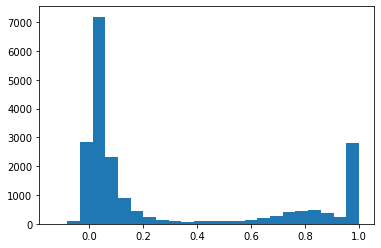

In [ ]:
plt.hist(scores, bins='auto')
plt.show()